Cleaned data saved successfully.
Test 1 - Gender and Calories - t-statistic: 2.556, p-value: 0.011


<ipython-input-3-ba9c02d8d1c8>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Calories_per_Minute'] = df_cleaned['Calories'] / df_cleaned['Duration']
<ipython-input-3-ba9c02d8d1c8>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Calorie_Efficiency'] = pd.qcut(df_cleaned['Calories_per_Minute'], 3,
<ipython-input-3-ba9c02d8d1c8>:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='Gender', y='Calories', data=df_cle

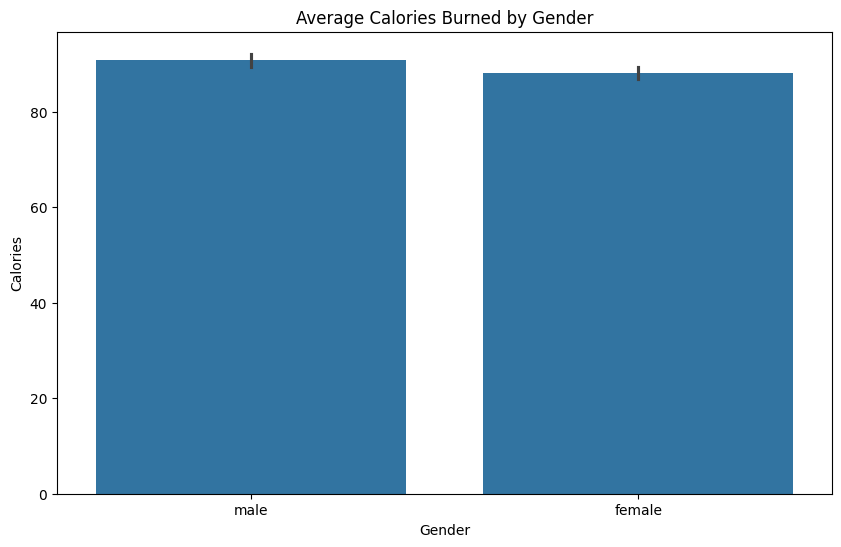

<ipython-input-3-ba9c02d8d1c8>:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups = df_cleaned.groupby('Age_Group')['Calories'].apply(list)
<ipython-input-3-ba9c02d8d1c8>:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_calories = df_cleaned.groupby('Age_Group')['Calories'].mean().reset_index()


Test 2 - Age Groups and Calories - F-statistic: 98.987, p-value: 0.000


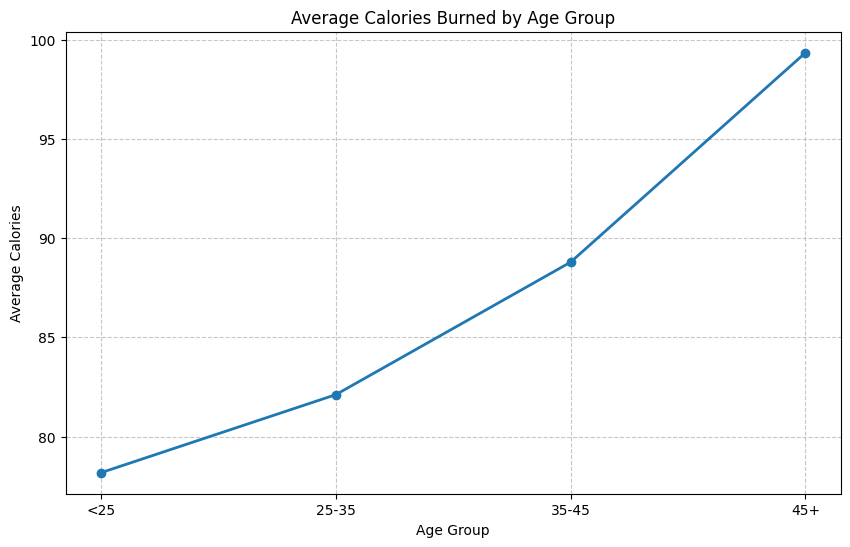

Test 3 - BMI Category and Calorie Efficiency - Chi-square: 179.081, p-value: 0.000


<Figure size 1200x700 with 0 Axes>

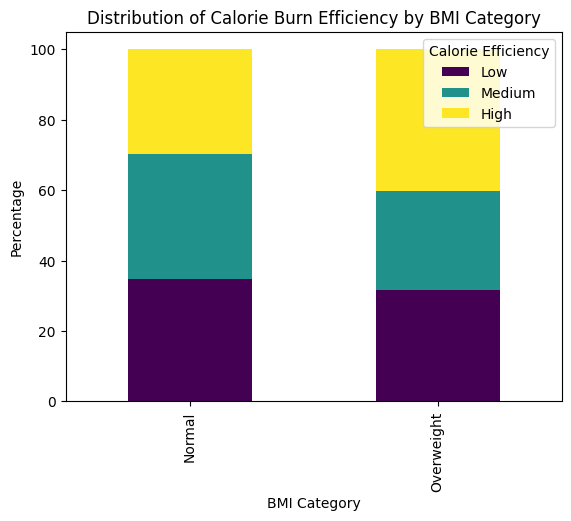

Test 4 - Heart Rate and Calories - R-squared: 0.806, p-value: 0.000


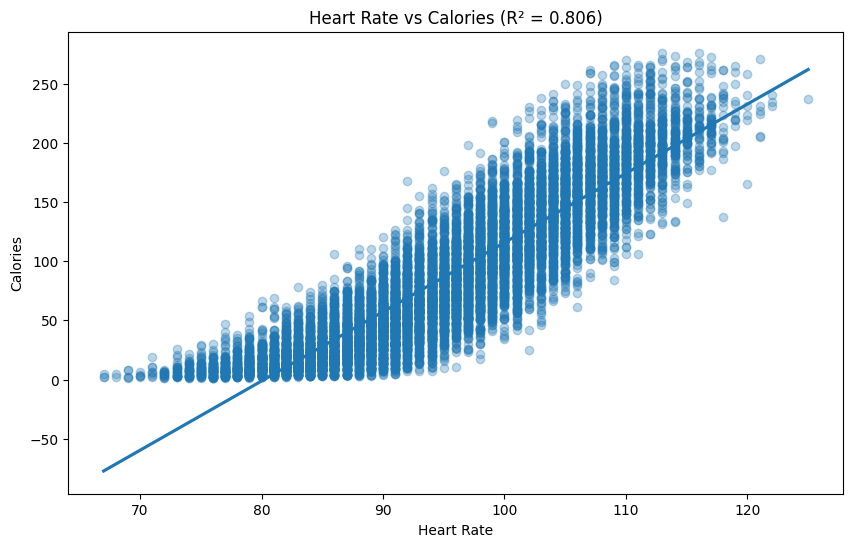

Test 5 - Multiple Regression - R-squared: 0.947, p-value: 0.000
                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 8.882e+04
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:27:49   Log-Likelihood:                -61243.
No. Observations:               14993   AIC:                         1.225e+05
Df Residuals:                   14989   BIC:                         1.225e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

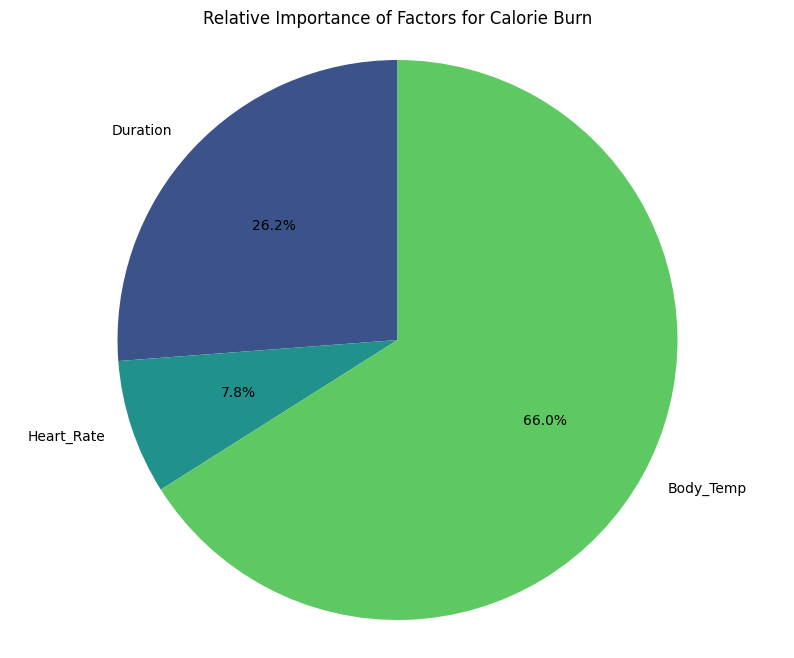

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# PART 1: Data Cleaning
# =====================

# Read CSV files
try:
    calories_df = pd.read_csv('calories.csv.xls')
    exercise_df = pd.read_csv('exercise.csv.xls')

    # Merge datasets
    df = pd.merge(exercise_df, calories_df, on='User_ID')

    # Clean NULL values
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            df[column].fillna(df[column].mean(), inplace=True)

    # Remove duplicates
    df = df.drop_duplicates()

    # Calculate BMI
    if 'Weight' in df.columns and 'Height' in df.columns:
        df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)
        df['BMI_Category'] = pd.cut(df['BMI'],
                              bins=[0, 18.5, 25, 30, 100],
                              labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

    # Create age groups
    if 'Age' in df.columns:
        df['Age_Group'] = pd.cut(df['Age'],
                            bins=[0, 25, 35, 45, 100],
                            labels=['<25', '25-35', '35-45', '45+'])

    # Function to remove outliers
    def remove_outliers(df, column, z_threshold=3):
        z_scores = stats.zscore(df[column])
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < z_threshold)
        return df[filtered_entries]

    # Remove outliers from Calories
    df_cleaned = remove_outliers(df, 'Calories')

    # Save cleaned data
    df_cleaned.to_csv('processed_fitness_data_cleaned.csv', index=False)
    print("Cleaned data saved successfully.")

except Exception as e:
    print(f"Error in data cleaning: {e}")
    # If cleaning fails, try to load existing cleaned data
    try:
        df_cleaned = pd.read_csv('processed_fitness_data_cleaned.csv')
        print("Loaded existing cleaned data.")
    except:
        # If that fails too, use the original merged data
        print("Using original merged data without cleaning.")
        df_cleaned = df

# PART 2: Hypothesis Tests
# =======================

# Add calorie efficiency column for later use
df_cleaned['Calories_per_Minute'] = df_cleaned['Calories'] / df_cleaned['Duration']
# Create a categorical variable for chi-square test
df_cleaned['Calorie_Efficiency'] = pd.qcut(df_cleaned['Calories_per_Minute'], 3,
                                          labels=['Low', 'Medium', 'High'])

try:
    ### Test 1: Gender and Calorie Burn Relationship (t-test with bar chart)
    if 'Gender' in df_cleaned.columns:
        male_data = df_cleaned[df_cleaned['Gender'] == 'male']['Calories']
        female_data = df_cleaned[df_cleaned['Gender'] == 'female']['Calories']

        t_stat, p_val = stats.ttest_ind(male_data, female_data)
        print(f"Test 1 - Gender and Calories - t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

        # Create bar chart
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Gender', y='Calories', data=df_cleaned, ci=95)
        plt.title('Average Calories Burned by Gender')
        plt.ylabel('Calories')
        plt.savefig('gender_calories_bar.png')
        plt.show()

    ### Test 2: Age Groups and Calorie Burn (ANOVA with line chart)
    if 'Age_Group' in df_cleaned.columns:
        age_groups = df_cleaned.groupby('Age_Group')['Calories'].apply(list)
        f_stat, p_val = stats.f_oneway(*age_groups)
        print(f"Test 2 - Age Groups and Calories - F-statistic: {f_stat:.3f}, p-value: {p_val:.3f}")

        # Create line chart
        plt.figure(figsize=(10, 6))
        age_calories = df_cleaned.groupby('Age_Group')['Calories'].mean().reset_index()
        plt.plot(age_calories['Age_Group'], age_calories['Calories'], marker='o', linewidth=2)
        plt.title('Average Calories Burned by Age Group')
        plt.ylabel('Average Calories')
        plt.xlabel('Age Group')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig('age_calories_line.png')
        plt.show()

    ### Test 3: BMI Category and Calorie Efficiency (Chi-Square with stacked bar chart)
    if 'BMI_Category' in df_cleaned.columns and 'Calorie_Efficiency' in df_cleaned.columns:
        # Remove categories with too few samples for chi-square test
        valid_categories = df_cleaned['BMI_Category'].value_counts()[df_cleaned['BMI_Category'].value_counts() > 5].index
        df_chi = df_cleaned[df_cleaned['BMI_Category'].isin(valid_categories)]

        contingency = pd.crosstab(df_chi['BMI_Category'], df_chi['Calorie_Efficiency'])
        chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
        print(f"Test 3 - BMI Category and Calorie Efficiency - Chi-square: {chi2:.3f}, p-value: {p_val:.3f}")

        # Create stacked bar chart
        plt.figure(figsize=(12, 7))
        contingency_pct = contingency.div(contingency.sum(axis=1), axis=0) * 100
        contingency_pct.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title('Distribution of Calorie Burn Efficiency by BMI Category')
        plt.xlabel('BMI Category')
        plt.ylabel('Percentage')
        plt.legend(title='Calorie Efficiency')
        plt.savefig('bmi_calorie_efficiency_stacked.png')
        plt.show()

    ### Test 4: Heart Rate and Calorie Burn Relationship (Regression with scatter plot)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_cleaned['Heart_Rate'], df_cleaned['Calories'])
    print(f"Test 4 - Heart Rate and Calories - R-squared: {r_value**2:.3f}, p-value: {p_value:.3f}")

    # Create scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(x='Heart_Rate', y='Calories', data=df_cleaned, scatter_kws={'alpha':0.3})
    plt.title(f'Heart Rate vs Calories (R² = {r_value**2:.3f})')
    plt.xlabel('Heart Rate')
    plt.ylabel('Calories')
    plt.savefig('heart_rate_calories_regression.png')
    plt.show()

    ### Test 5: Duration's Impact on Calorie Burn (Multiple regression with pie chart)
    X = df_cleaned[['Duration', 'Heart_Rate', 'Body_Temp']]
    X = sm.add_constant(X)
    y = df_cleaned['Calories']

    model = sm.OLS(y, X).fit()
    print(f"Test 5 - Multiple Regression - R-squared: {model.rsquared:.3f}, p-value: {model.f_pvalue:.3f}")
    print(model.summary())

    # Extract coefficients and create pie chart of relative importance
    coef = model.params[1:]  # Skip the constant
    abs_coef = np.abs(coef)
    importance = abs_coef / abs_coef.sum() * 100

    plt.figure(figsize=(10, 8))
    plt.pie(importance, labels=importance.index, autopct='%1.1f%%', startangle=90,
            colors=sns.color_palette('viridis', len(importance)))
    plt.title('Relative Importance of Factors for Calorie Burn')
    plt.axis('equal')
    plt.savefig('calorie_factors_importance_pie.png')
    plt.show()

except Exception as e:
    print(f"Error in hypothesis testing: {e}")